In [1]:
# import library's 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
# https://pypi.org/project/pca/
from pca import pca
%matplotlib inline


## Exploring the dataset

This dataset is from the US Arrests Kaggle challenge. A description of the
data is given as: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

In [2]:
# read countries csv
df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))
# 

Number of cases: 50 Number of features: 4


The mean, standard deviation, range, and distribution of each variable, as well as the number of missing values per variable, are observed. This is summarised in the table below.

In [4]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
selected_stats = df.describe().loc[["mean","std","min","max"]].transpose() #select relevant rows
# Count missing values
relevant_missing = pd.DataFrame(df.isnull().sum(), columns=["missing"])
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary

,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


At first glance, Assault stands out as having a mean and standard deviation which are significantly higher than the other variables. The data will be scaled to keep assault from impacting the analysis disproportionately.

The statistics for 50 US states are arrest made per 100 000 residents for 3 types of crimes: murder, assault and rape. The objective of this report will be to create an in-depth PCA report, interpret the outcome of any analyses and apply two clustering techniques to examine how each crime attributes itself to each state.  City will be the response variable and crime and population are the predictor variables. 

The info table below shows that the data has 5 features, 0 missing values and mixed data types. 

In [5]:
# understand the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


All predictor variables are converted to the same datatype.

In [6]:
# make numerical features all float types
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')

Below histograms show the distribution of the observations for each feature

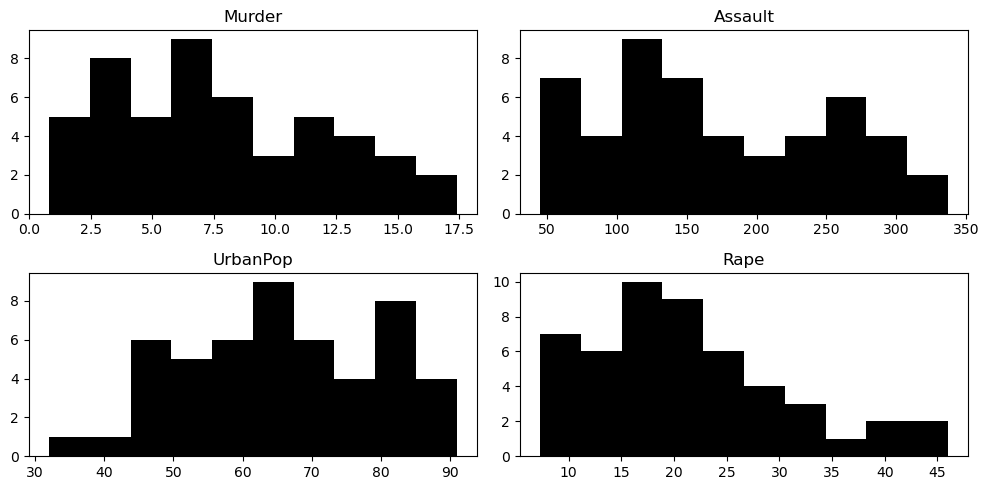

In [7]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 5)) 
plt.tight_layout()

The boxplot below shows spread of the data. We can see that assault has a larger spread and medium compared to the other features. The data will be scaled so that Assault doesn't bias the modals.

Text(0.5, 1.0, 'Data Distribution of the Four features')

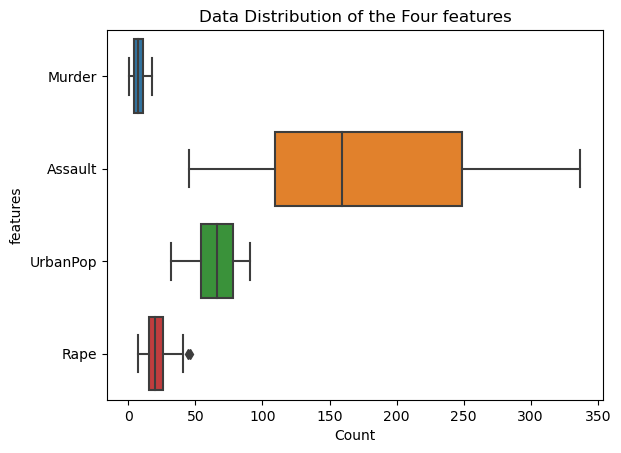

In [8]:
# creating a boxplot for feature distribution
sns.boxplot(data=df, orient='h')
plt.ylabel('features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four features')

Observations:

- top 5 highest murder rate : Georgia, Mississippi, Florida, Louisiana, South Carolina
- top 5 lowest murder rate : North Dakota, New Hampshire, Maine, Iowa, Vermont

- top 5 highest assault :  North Carolina, Florida, Maryland, Arizona, New Mexico
- top 5 lowest assault :  North Dakota, Hawaii, Vermont, Wisconsin, Iowa

- top 5 highest rape : Nevada, Alaska, California, Colorado, Michigan
- top 5 lowest rape : North Dakota, Maine, Rhode Island, West Virginia, New Hampshire

- top 5 highest UrbanPop : California, New Jersey, Rhode Island, New York, Massachusetts
- top 5 lowest UrbanPop : Vermont, West Virginia, North Dakota, Mississippi, South Dakota


CORRELATION ANALYSIS

From the correlation plot, as expected, murder and assault has a strong positive correlation and rape and assault is relatively strong. UrbanPop has a relatively low correlation against all the variables, tracking slightly higher with rape.   Although, it's hard to make comparisons, because UrbanPop is a percentage value representing population of residents within each state, while number of murders, rapes and assaults are all distinct numeric values that are not represented as percentages. Nevertheless, variables with strong correlation suggests that the data may be a good candidate for PCA. PCA will be able to reduce variables which encode similar types of differences between features in a way that requires fewer dimensions.

Text(0.5, 1.0, 'Correlation Heatmap of US Arrests')

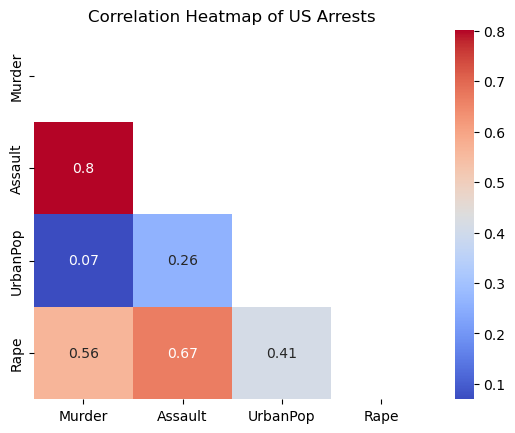

In [9]:
# corr heatmap to see how our data features correlate
cities = df.index
labels = df.columns
arrest_corr = df.corr()
# to mask mirrored side of heatmap
mask_ut=np.zeros_like(arrest_corr)
mask_ut[np.triu_indices_from(mask_ut)] = True
# mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)

# heatmap
sns.heatmap(arrest_corr, mask=mask_ut, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of US Arrests")


Data will be scaled so that one feature doesn't dominate another.

In [10]:
# select independent and standardise features
scaled = StandardScaler().fit_transform(df.loc[:,['Murder', 'Assault', 'UrbanPop', 'Rape']])
# create scaled version of df
df_scaled = pd.DataFrame(scaled, columns = ['Murder', 'Assault', 'UrbanPop', 'Rape'])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.26,0.79,-0.53,-0.00
1,0.51,1.12,-1.22,2.51
2,0.07,1.49,1.01,1.05
3,0.23,0.23,-1.08,-0.19
4,0.28,1.28,1.78,2.09


## PCA Standardised Data

Components for PCA

The graph below and the explained variance ratio shows component 1 contains 62% of all explained variances within our data. Component 2 contains 24.74% of all explained variance. To principle components achieves 86.74% explanation of variance within our data, which is an acceptable threshold. 

In [11]:
# showing how each component attributes itself to explain variance
pca_modal = PCA().fit(df_scaled)
print(f"Proportion of Variance Explained: {pca_modal.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca_modal.explained_variance_)}")


Proportion of Variance Explained: [0.62006039 0.24744129 0.0891408  0.04335752]
Cumulative Proportion: [2.53085875 3.5408232  3.90466318 4.08163265]


Text(2.5, 85.5, '85% threshold')

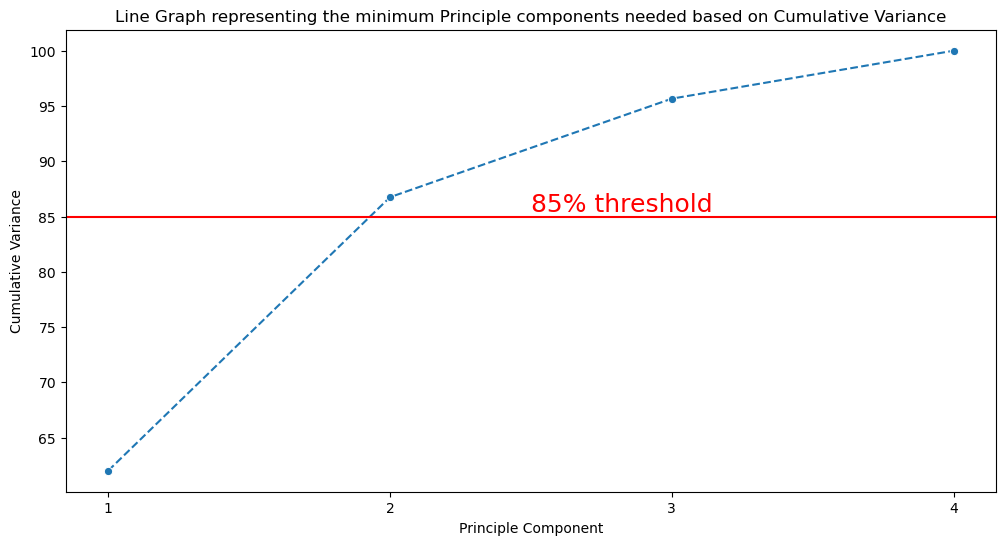

In [12]:
# graph to show the minimum number of components needed for analysis
X = np.arange(1, 5, 1)
plt.figure(figsize=(12,6))
sns.lineplot(x=X, y = np.cumsum(pca_modal.explained_variance_ratio_)*100, linestyle='--', marker='o')

plt.title('Line Graph representing the minimum Principle components needed based on Cumulative Variance')
plt.xlabel('Principle Component')
plt.xticks(np.arange(1, 5, 1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color = 'red', fontsize=18) 

The analysis will proceed with 2 components

In [13]:
# PCA analysis 2 components
pca_modal = PCA(n_components=2)

# obtain components
principal_components = pca_modal.fit_transform(df_scaled)
principal_components.shape

(50, 2)

PCA model with n components 2 transformed into a Pandas dataframe, setting state names to index.

In [14]:
# index
cities = df.index
#feature labels
labels = df.columns
# transform the components into a pandas data frame
pc_df = pd.DataFrame(data = principal_components, columns=['principal_component_1', 'principal_component_2'])
pc_df.set_index(cities, inplace=True)
pc_df.head()

,principal_component_1,principal_component_2
City,,
Alabama,0.99,1.13
Alaska,1.95,1.07
Arizona,1.76,-0.75
Arkansas,-0.14,1.12
California,2.52,-1.54


The barplot below shows variance explained by principle components.

<AxesSubplot:title={'center':'Variance Explained by principle components'}, xlabel='principal_component', ylabel='variance_explained'>

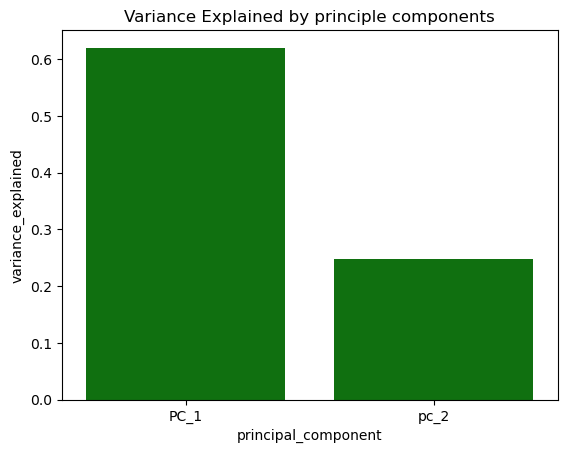

In [15]:
# barplot to visually represent how each component affects the variance
df_var = pd.DataFrame({'variance_explained': pca_modal.explained_variance_ratio_, 'principal_component': ['PC_1', 'pc_2']})
plt.title('Variance Explained by principle components')
sns.barplot(x='principal_component', y='variance_explained', data=df_var, color='g')

In [16]:
# function for biplot us arrest pca data
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15, 10))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        # index col
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

The biplot visualizes the principal components from the DataFrame, using numeric labels to indicate the correlation between features.

[scatterd] >INFO> Hex [[0, 0, 0]] should be of type string
[scatterd] >INFO> Create scatterplot


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


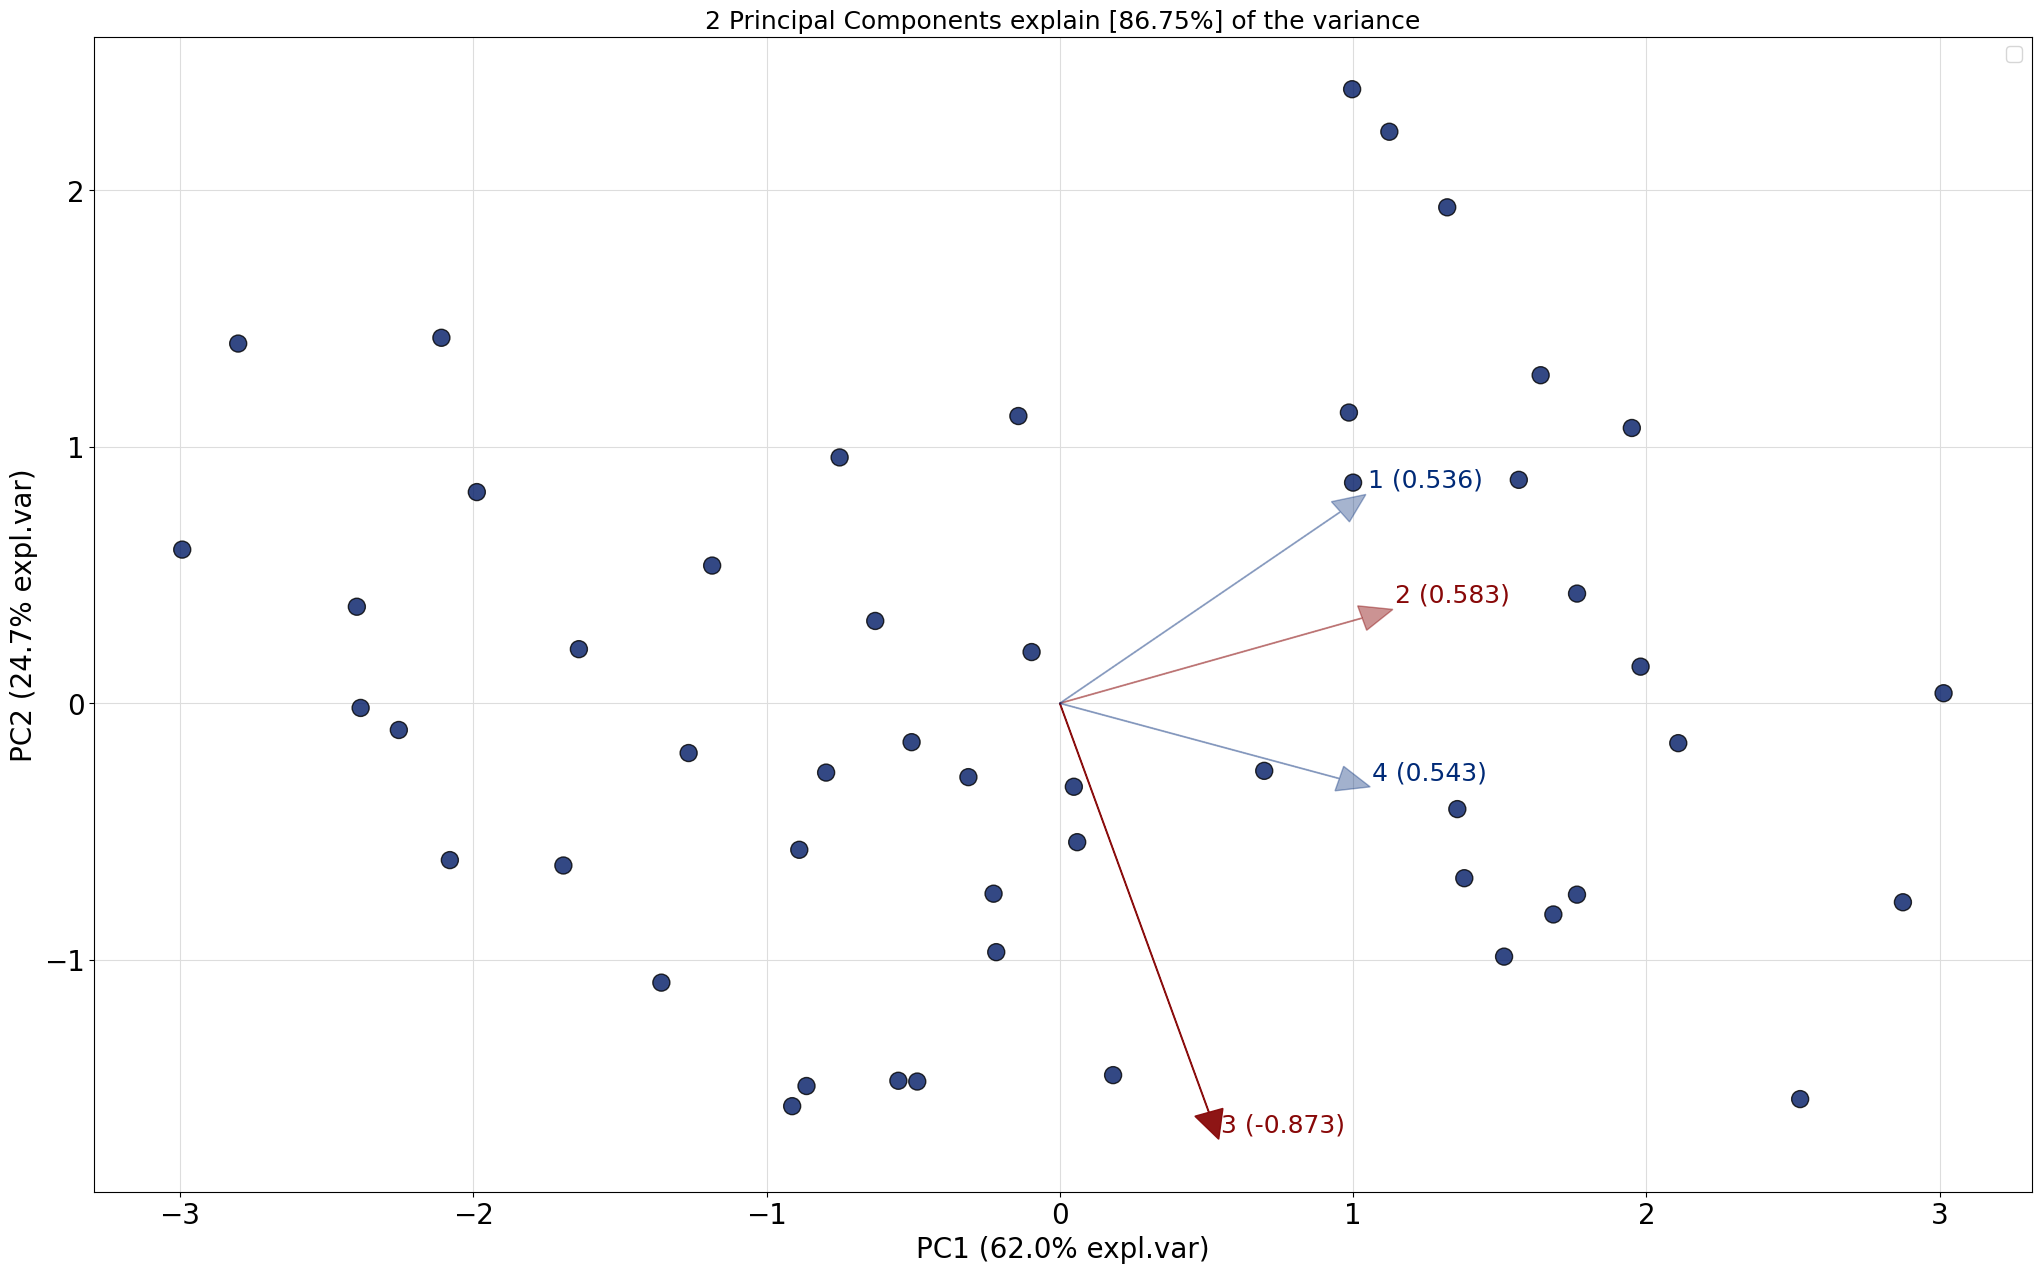

In [17]:
# biblot to represent components within the total Dataframe with numeric labels
model = pca(n_components=2)
# Fit transform
results = model.fit_transform(scaled)
# Plot explained variance
# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)


Second biplot represents components within the total DataFrame with feature labels.

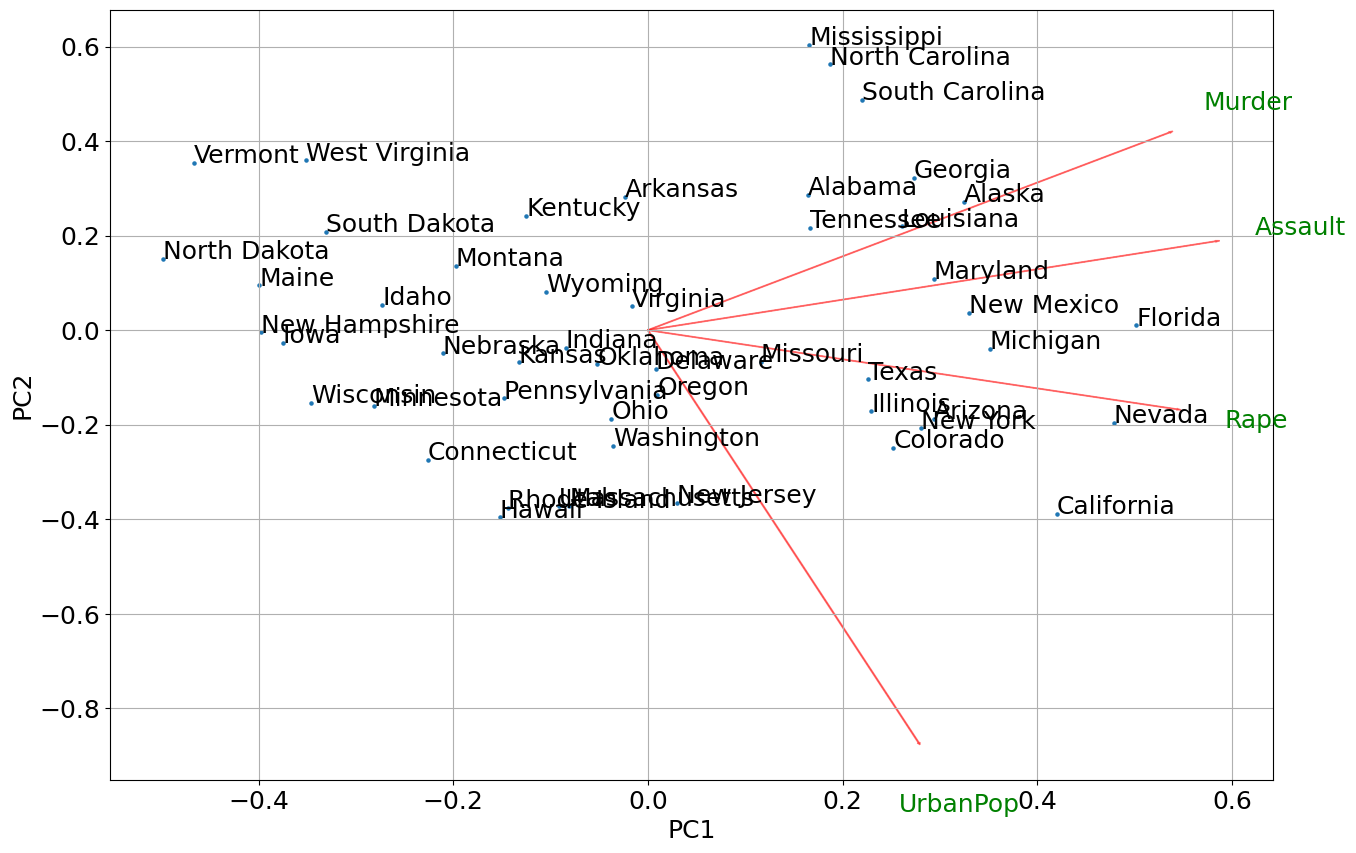

In [18]:
# biplot to represent components within the total DataFrame with labels
biplot(
    principal_components[:,0:2],
    np.transpose(pca_modal.components_[0:2, :]), 
    labels= labels
)


The biplots display observations as points in the plane formed by the first two principal components. These observations represent different states. The vectors in the biplot correspond to the variables: Murder, Assault, Rape, and Urban Population.

The cosine of the angle between a vector and a principal component axis represents the contribution of the associated variable to that principal component. Additionally, the cosine of the angle between pairs of vectors signifies the correlation between the respective variables. Vectors that point in similar directions indicate highly correlated variables, while those close to perpendicular suggest little to no correlation.

In [19]:
# Feature importance
# Set float display format for better readability
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Calculate the absolute importance of features for the first two principal components
pc1 = abs(pca_modal.components_[0])
pc2 = abs(pca_modal.components_[1])

# Create a DataFrame to display feature importance
feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df


,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance from the table above, it appears that most of the variables contribute fairly evenly to both principal components, except for 'UrbanPop'. In both PC1 and PC2, 'UrbanPop' has the highest contribution.

Overall, I interpret PC1 as primarily a measure of violent crime, given the significant contributions from 'Murder', 'Assault', and 'Rape'. On the other hand, PC2 seems to be more indicative of the level of urbanization due to the dominant influence of 'UrbanPop'.

## Cluster Analysis

Hierarchical Clustering and K-means will be performed using PCA modal data and the results compared.

# K-means analysis

K-means finds observations that share characteristics and classifies them together into clusters.  To determine k clusters the elbow method will be used. The below elbow method will run k means clustering on the dataset for a range 1 to 10 k values and for each value of k compute an average score for all clusters.  

Text(0, 0.5, 'Reduction in variance')

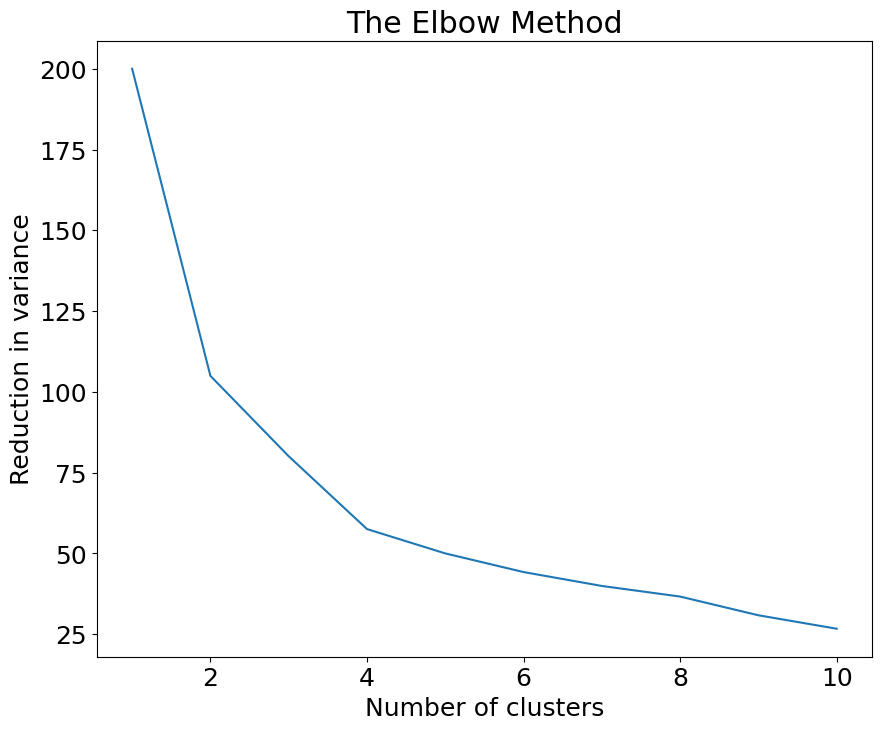

In [20]:
#Finding the optimum number of clusters for k-means classification
#within cluster sum of squares
wcss = []
plt.figure(figsize=(10,8))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

lp = sns.lineplot(y=wcss, x=range(1, 11))
lp.set_title('The Elbow Method')
lp.set_xlabel('Number of clusters')
lp.set_ylabel('Reduction in variance') #within cluster sum of squares



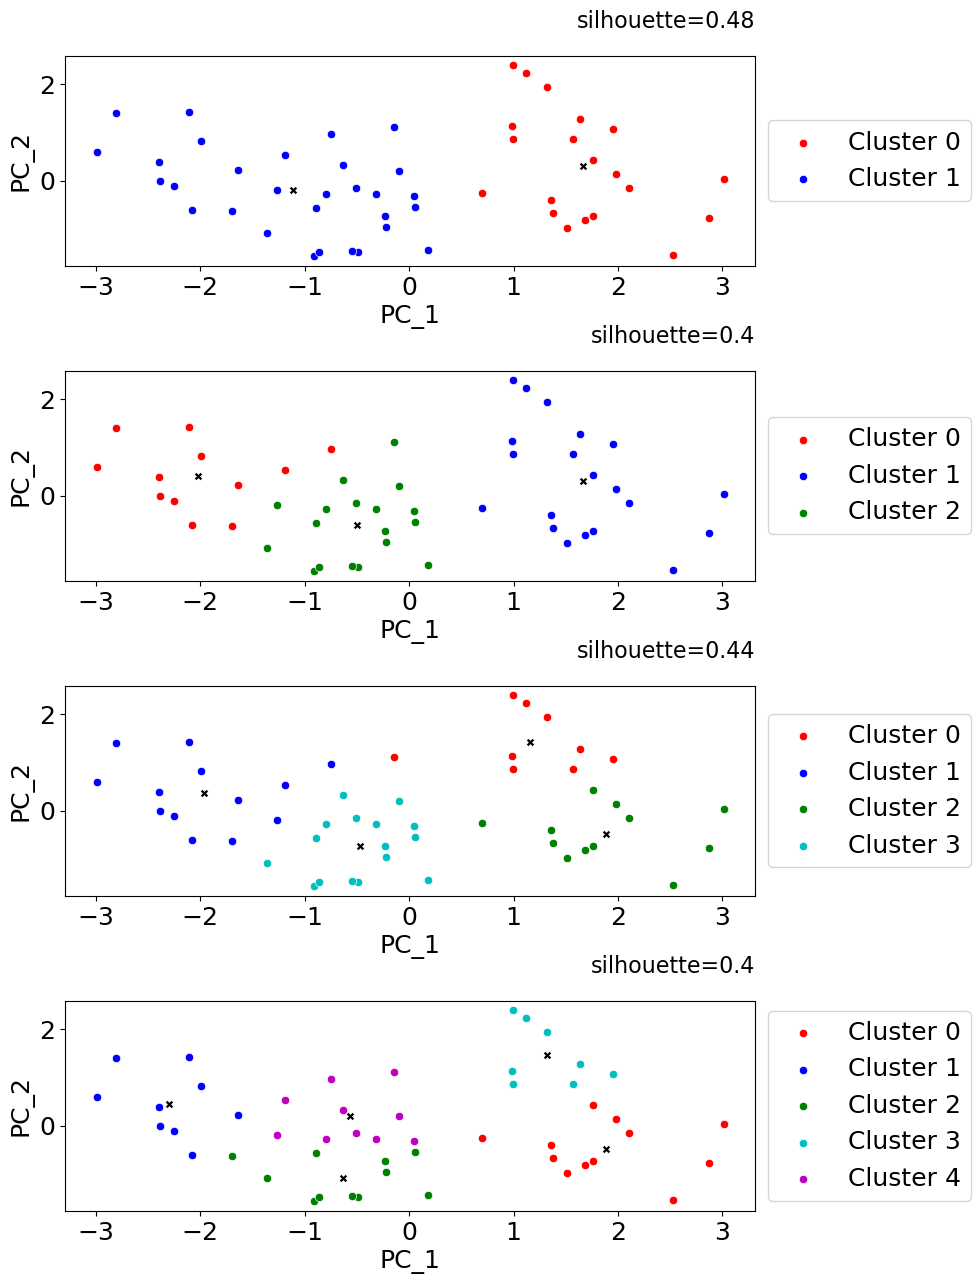

In [28]:
def scatter_Kmeans(x, k, i, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init = 10, random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = ['r', 'b', 'g', 'c', 'm', 'y']
    for c in range(k):
        sns.scatterplot(
            x=x[y_pred == c, 0], 
            y=x[y_pred == c, 1], 
            color=colours[c], 
            label=f'Cluster {c}', 
            ax=ax[i]
        )

    sns.scatterplot(
        x=[cluster[0] for cluster in kmeans.cluster_centers_], 
        y=[cluster[1] for cluster in kmeans.cluster_centers_], 
        marker='X', 
        color='black', 
        ax=ax[i]
    )
    
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    ax[i].set_title(f'silhouette={score}', loc='right', fontdict={'fontsize': 16}, pad=20)
    ax[i].set_xlabel('PC_1')
    ax[i].set_ylabel('PC_2')
    
    # Positioning the legend to the right outside the plot
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

k_test = range(2,6)    
fig, ax = plt.subplots(len(k_test), 1, figsize=(12, 15))  # Slightly increased the figure width
for i, k in enumerate(k_test):
    scatter_Kmeans(principal_components, k, i, r=0)

plt.subplots_adjust(hspace=0.5, right=0.7)  # Adjusted right space and vertical spacing



n_clusters 4 and 2 was chosen for investigation based on the highest sihouette score and the elbow method graph.  

K-means model with 4 n_clusters:

[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


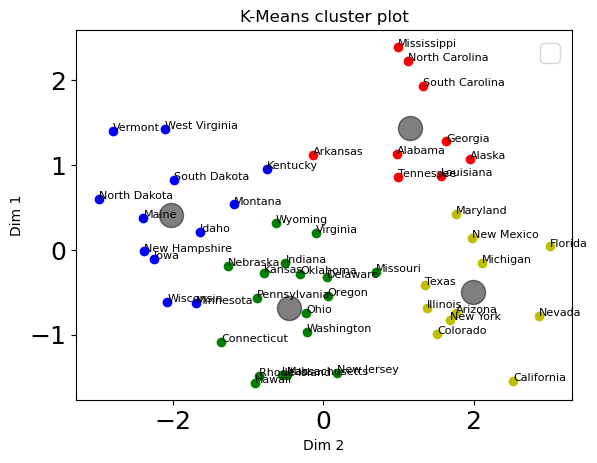

In [76]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(pc_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0, k):
    ax.scatter(x[cluster_labels == i], y[cluster_labels == i], c=colours[i])
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c="black", s=300, alpha=0.5)

for i in range(0, len(x)):
    txt = cities[i]
    ax.annotate(txt, (x[i], y[i]), fontsize=8)  # Adjust the fontsize here

ax.set_title("K-Means cluster plot", fontsize=12)
ax.set_xlabel("Dim 2", fontsize=10)
ax.set_ylabel("Dim 1", fontsize=10)
ax.legend()


Silhouette score

In [30]:
print(f'Silhouette score: {silhouette_score(principal_components, cluster_labels)}')

Silhouette score: 0.4439777353995337


Below code adds cluster information to original dataframe for investigating.

In [31]:
# indexes are grouped by elements, assigned cluster group
# adds cluster group to df
def add_cluster_groups(modal_fit, col_name):
    group0_indices = np.argwhere(modal_fit==0).transpose()[0]
    group1_indices = np.argwhere(modal_fit==1).transpose()[0]
    group2_indices = np.argwhere(modal_fit==2).transpose()[0]
    group3_indices = np.argwhere(modal_fit==3).transpose()[0]

    group0 = np.array(cities)[group0_indices]
    group1 = np.array(cities)[group1_indices]
    group2 = np.array(cities)[group2_indices]
    group3 = np.array(cities)[group3_indices]

    # add cluster group to dataframe
    for c in cities:
        if c in group0:
            df.at[c, col_name] = 1
        elif c in group1:
            df.at[c, col_name] = 2
        elif c in group2:
            df.at[c, col_name] = 3
        elif c in group3:
            df.at[c, col_name] = 4
        else:
            df.at[c, col_name] = 99

Summary of the data grouped by clusters.

In [32]:
# add cluster groups for k = 4 to df
add_cluster_groups(cluster_labels, 'k_4cluster')

# mean summary cluster k=4
#     .agg(["mean","std","min","max"])
(
    df
    .groupby(['k_4cluster'])
    .mean()
    .reset_index()
)

,k_4cluster,Murder,Assault,UrbanPop,Rape
0,1.000,13.500,245.778,53.111,23.978
1,2.000,3.542,76.583,51.250,11.817
2,3.000,5.767,139.000,73.000,19.178
3,4.000,11.055,264.091,79.091,32.618


Cluster 1 states have a high average of Assault cases (264.091) compared to the other clusters, a relatively high average of UrbanPop (79.091) indicating they are more urban, and also have a higher average number of Murder (11.055) and Rape cases (32.618). These could be heavily populated urban areas with high crime rates.

Cluster 2 states have the lowest averages across all variables: Murder (3.6), Assault (78.538), UrbanPop (52.077), and Rape (12.177). These could represent smaller, more rural states with overall lower crime rates.

Cluster 3 states have the highest average number of Murder cases (13.5) and a relatively high average of Assault cases (245.778), but a lower average UrbanPop (53.111). This could indicate these are states with high crime rates but aren't necessarily the most urbanized.

Cluster 4 states have an average Murder rate (5.853) which is lower than Cluster 1 and 3, but higher than Cluster 2. They have a relatively lower average Assault rate (141.176) and a middle-of-the-road UrbanPop rate (73.647). This might suggest a mixed set of states, potentially suburban regions, with moderate crime rates.

In [70]:
def plot_boxplots(cluster_column, data):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    
    features = ['Murder', 'Rape', 'Assault', 'UrbanPop']

    for i, feature in enumerate(features):
        sns.boxplot(x=cluster_column, y=feature, data=data, ax=ax[i])
        ax[i].set_xlabel('')  # Remove the x-labels
        
        # Set the title for the first subplot only (to save space)
        if i == 0:
            ax[i].set_title(cluster_column)

    fig.tight_layout(w_pad=2.0)  # Adding horizontal padding between plots


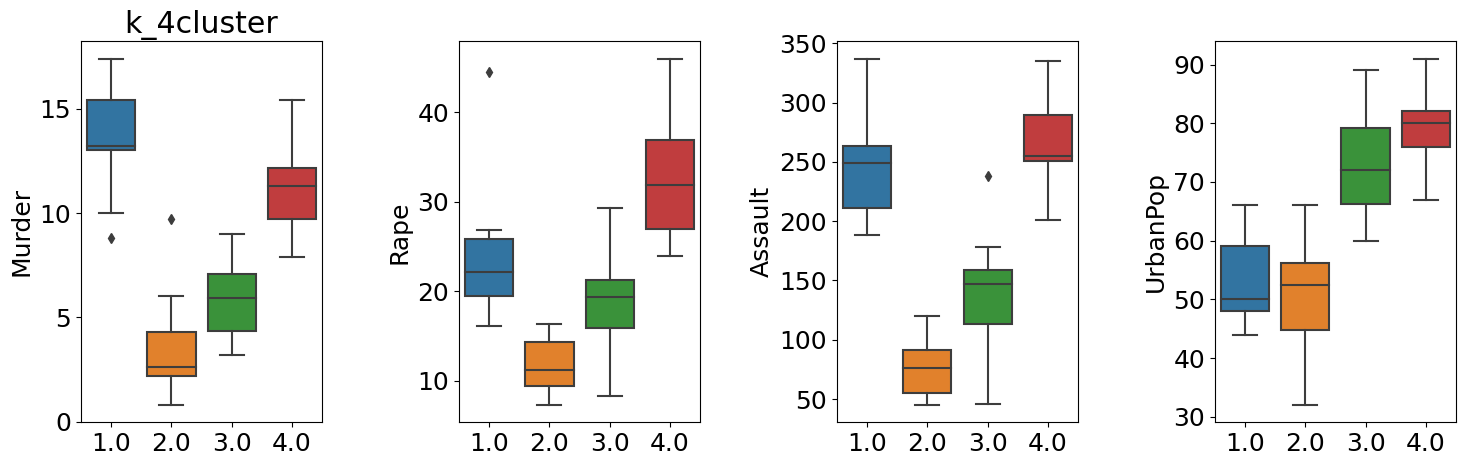

In [71]:
# Boxplots to display distribution of crime rates for the states in cluster 1 to 4.
plot_boxplots('k_4cluster', df)

From the box plots above, 

Cluster 1 states has higher rates of arrest across all features and higher UrbanPop.  Cluster 4 states also has relatively higher UrbanPop, but interesting has relatively low rates of arrest across all features compared to cluster 1.

Cluster 2 states has relatively low rates of arrest across all features and lower medium urbanPop compared to clusters 1 and 4. And a larger spread of states with lower percentage score in urbanPop.

Cluster 3 has relatively high rates of arrest across all features, but lower urbanPop.

The plot also shows some outliers in the data.

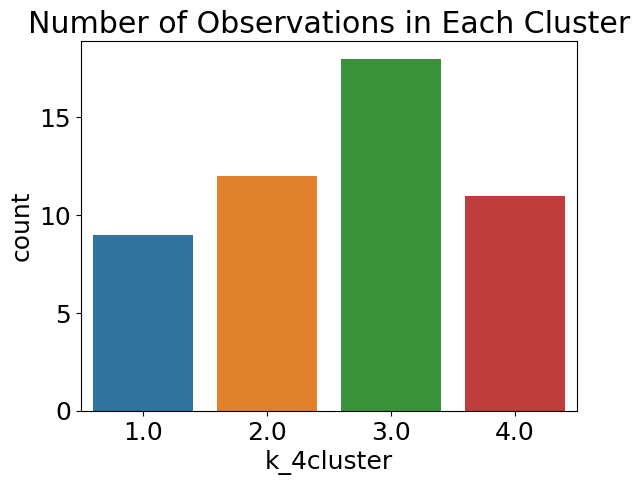

In [34]:
sns.countplot(x='k_4cluster', data=df)
plt.title('Number of Observations in Each Cluster')
plt.show()


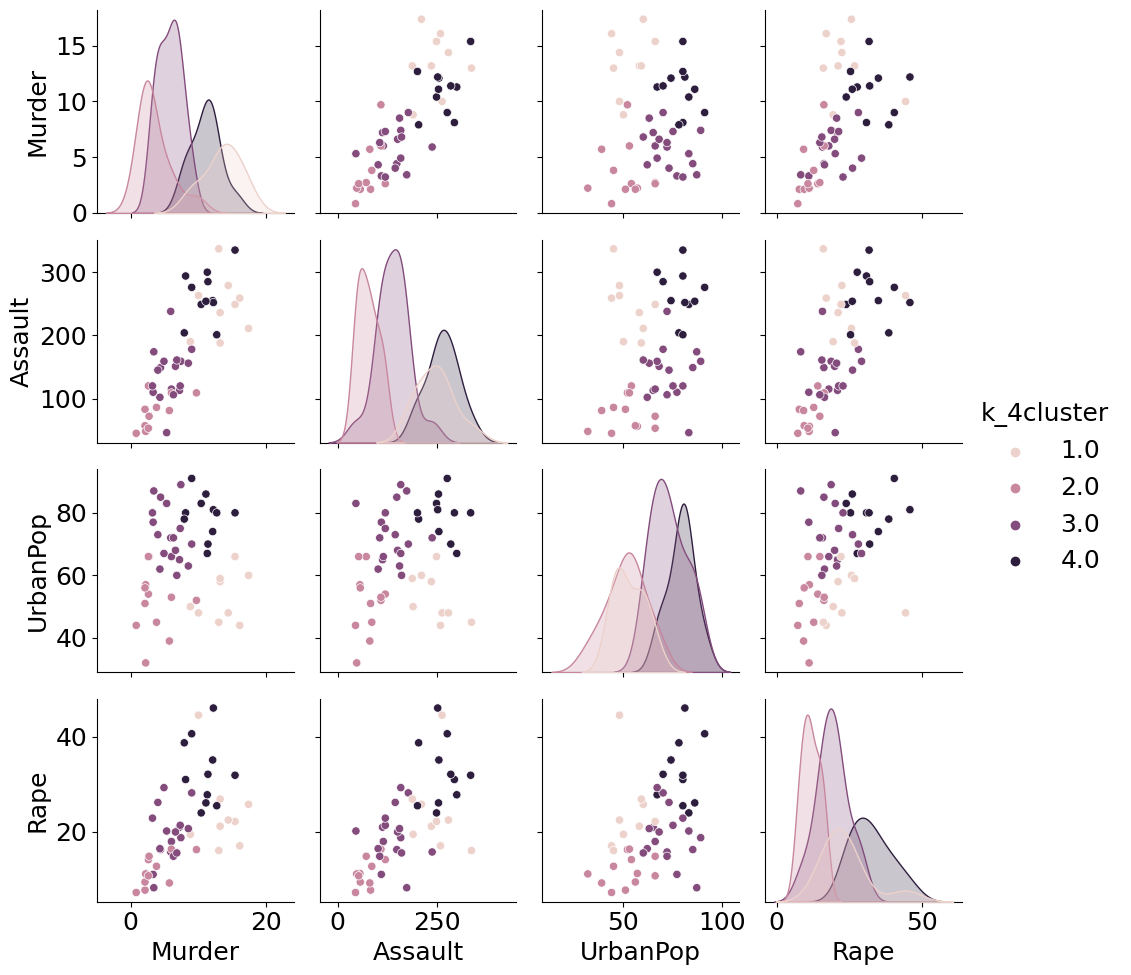

In [35]:
# Pairwise relationships between features in each cluster
sns.pairplot(df, vars=['Murder', 'Assault', 'UrbanPop', 'Rape'], hue='k_4cluster')
plt.show()


K-means model with 2 n_clusters:

[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


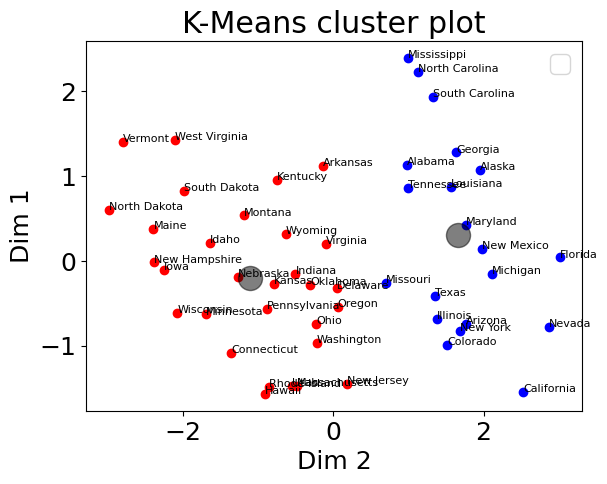

In [77]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', n_init =10, random_state=42)
cluster_labels2 = kmeans.fit_predict(pc_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels2 == i],y[cluster_labels2 == i],c = colours[i]) 
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c = "black", s=300, alpha=0.5)


for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]), fontsize=8)
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

Silhouette score for k =2

In [37]:
print(f'Silhouette score: {silhouette_score(principal_components, cluster_labels2)}')

Silhouette score: 0.4758031477075563


In [38]:
# add cluster groups for k = 2 to df
add_cluster_groups(cluster_labels2, 'k_2cluster')

Summary of the data grouped by k=2 clusters.

In [39]:
# summary df
(
    df
    .drop(['k_4cluster'], axis=1)
    .groupby(['k_2cluster'])
    .mean()
    .reset_index()
)

,k_2cluster,Murder,Assault,UrbanPop,Rape
0,1.000,4.870,114.433,63.633,15.943
1,2.000,12.165,255.250,68.400,29.165


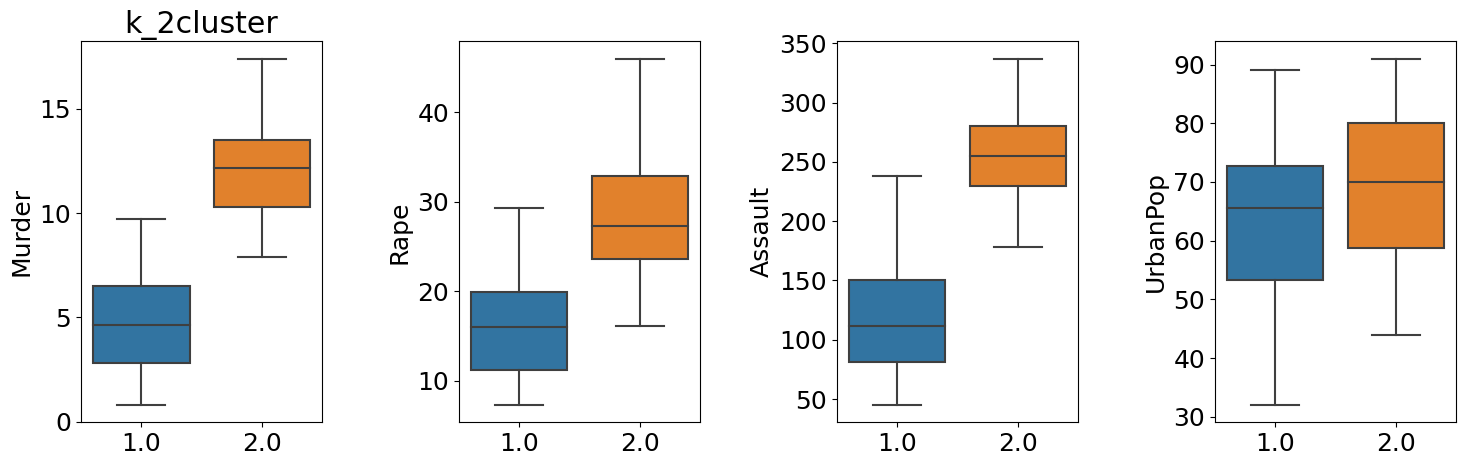

In [72]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.

plot_boxplots('k_2cluster', df)



From the box plots above, 

The states in cluster 1 has lower min/max and medium values for Murders,Assaults and Rapes compared to cluster 2.
The states in the cluster 2 has higher crime rates on average. There is some overlap, but on average cluster 2 can be categorized as high-risk States. Cluster 1 has a slightly lower medium and mean to cluster 2 for UrbanPop. It has a much larger spread and a lower min.  

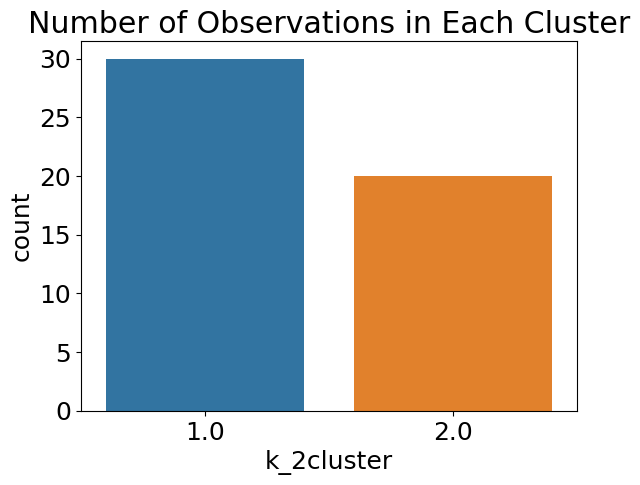

In [41]:
sns.countplot(x='k_2cluster', data=df)
plt.title('Number of Observations in Each Cluster')
plt.show()

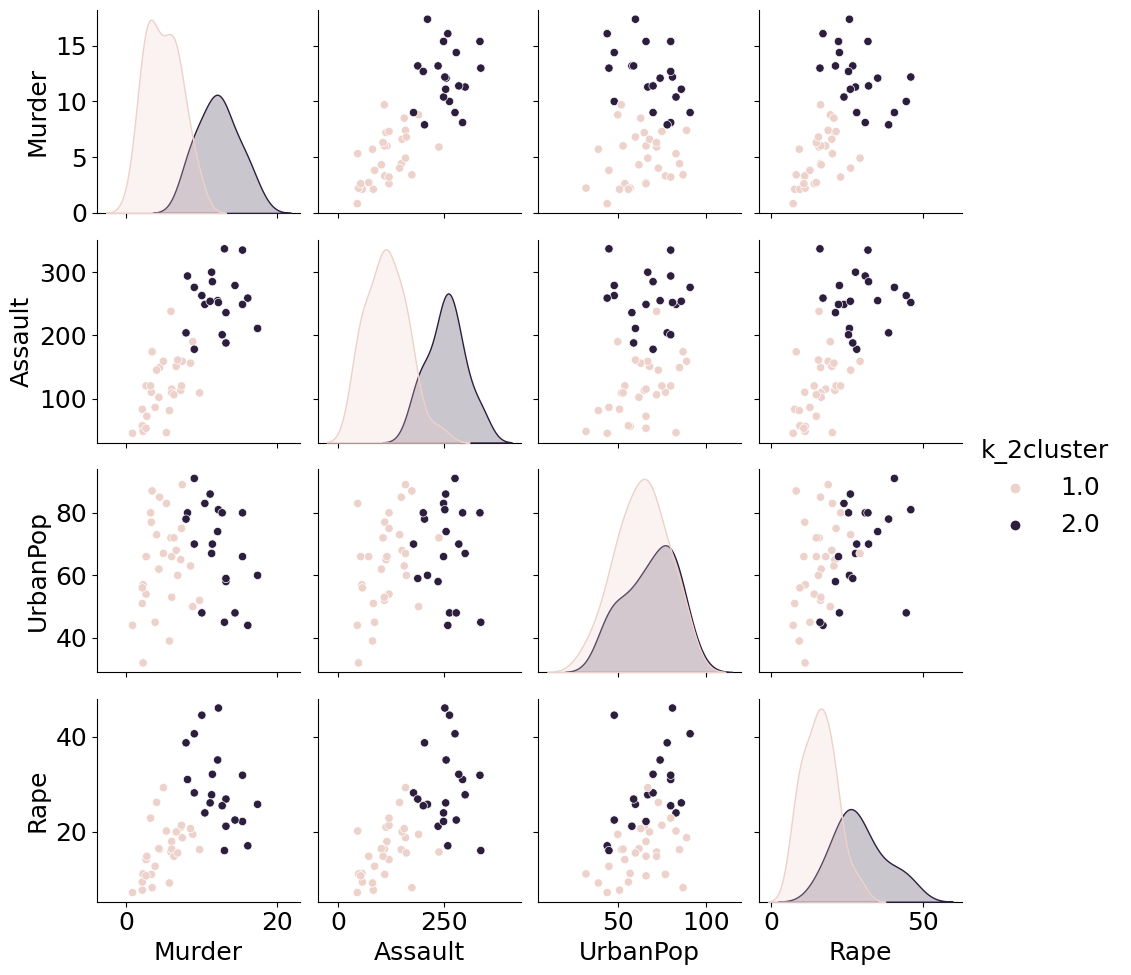

In [42]:
# Pairwise relationships between features in each cluster
sns.pairplot(df, vars=['Murder', 'Assault', 'UrbanPop', 'Rape'], hue='k_2cluster')
plt.show()

In the next part of our analysis, we will delve deeper into the k-means clustering results on the models with 2 and 4 clusters. To do so, we will create a new 'Crime Level' column in our dataset, categorizing each state according to their crime rates. Our objective will be to assess how effectively the clusters generated by the k-means algorithm align with these predefined crime levels. This will provide further insight into the meaningfulness of our clusters and their potential to reflect real-world categories of crime intensity.

In [43]:
# Create a copy of the original dataframe
df_crime_level = df.copy()

# Add new column 'CrimeLevel' to the dataframe
df_crime_level['CrimeLevel'] = 'medium-crime'  # default value

# High crime states: states where murder, assault, and rape rates are all above the median
high_crime_states = df_crime_level[(df_crime_level['Murder'] > df_crime_level['Murder'].median()) & 
                                   (df_crime_level['Assault'] > df_crime_level['Assault'].median()) & 
                                   (df_crime_level['Rape'] > df_crime_level['Rape'].median())].index

df_crime_level.loc[high_crime_states, 'CrimeLevel'] = 'high-crime'

# Low crime states: states where murder, assault, and rape rates are all below the median
low_crime_states = df_crime_level[(df_crime_level['Murder'] < df_crime_level['Murder'].median()) & 
                                  (df_crime_level['Assault'] < df_crime_level['Assault'].median()) & 
                                  (df_crime_level['Rape'] < df_crime_level['Rape'].median())].index

df_crime_level.loc[low_crime_states, 'CrimeLevel'] = 'low-crime'


k=4

Cluster 1 is mostly composed of "high-crime" states, with all 11 states in this category falling into this cluster. No states from the other two categories ("low-crime" and "medium-crime") fall into this cluster, suggesting that Cluster 1 may be distinctly capturing high-crime states.

Cluster 2 is largely made up of "low-crime" states. There are 12 "low-crime" states in this cluster, and only one "medium-crime" state. There are no "high-crime" states in Cluster 2. This suggests that Cluster 2 is effectively capturing low-crime states.

Cluster 3 has a mixture of "high-crime" and "medium-crime" states, with 6 states from the "high-crime" category and 3 from the "medium-crime" category. It does not contain any "low-crime" states.

Cluster 4 has a mix of states from all three categories. However, it mostly contains "medium-crime" states (11 out of 17 states in this cluster). It also includes 1 "high-crime" state and 5 "low-crime" states.

In summary, it appears that the K-means clustering algorithm, with 4 clusters, has been able to effectively segment the states into distinct groups that largely correspond to the original crime categories. Cluster 1 is predominantly made up of "high-crime" states, and Cluster 2 predominantly contains "low-crime" states. Cluster 3 seems to capture a blend of "high-crime" and "medium-crime" states. Cluster 4 is more mixed, but mostly contains "medium-crime" states. This suggests that the clustering is able to effectively distinguish between states with different crime levels, but there may be some overlap or ambiguity between the "medium-crime" category and the other two categories.

In [44]:
# Create a cross-tabulation
cross_tab = pd.crosstab(df_crime_level['k_4cluster'], df_crime_level['CrimeLevel'])

# Print the cross-tabulation
print(cross_tab)


CrimeLevel  high-crime  low-crime  medium-crime
k_4cluster                                     
1.000                6          0             3
2.000                0         11             1
3.000                1          6            11
4.000               11          0             0


k = 2

Cluster 1 contains 30 states, all of which are classified as 'low-crime' or 'medium-crime'. None of the 'high-crime' states have been grouped into Cluster 1.

Cluster 2 contains 20 states, 18 of which are classified as 'high-crime'. There are no 'low-crime' states in this cluster, but there are 2 'medium-crime' states.

Overall, this suggests that the k-means clustering did a good job of identifying 'high-crime' states, as all but two of them were grouped into Cluster 2. The model appears less clear on the distinction between 'medium-crime' and 'low-crime' states, as these are mixed in both clusters. However, since 'medium' represents an intermediate category, some overlap could be expected.

In [45]:
# Create a cross-tabulation
cross_tab = pd.crosstab(df_crime_level['k_2cluster'], df_crime_level['CrimeLevel'])

# Print the cross-tabulation
print(cross_tab)

CrimeLevel  high-crime  low-crime  medium-crime
k_2cluster                                     
1.000                0         17            13
2.000               18          0             2


## Hierarchical clustering

Agglomerative clustering using PCA data

Below we see the clusters visually in a dendrogram. In order to determine the method used to measure the distance between clusters, we plotted the various dendrograms for complete and average linkage methods. For the distance metric between observations, Euclidean and cityblock was used.

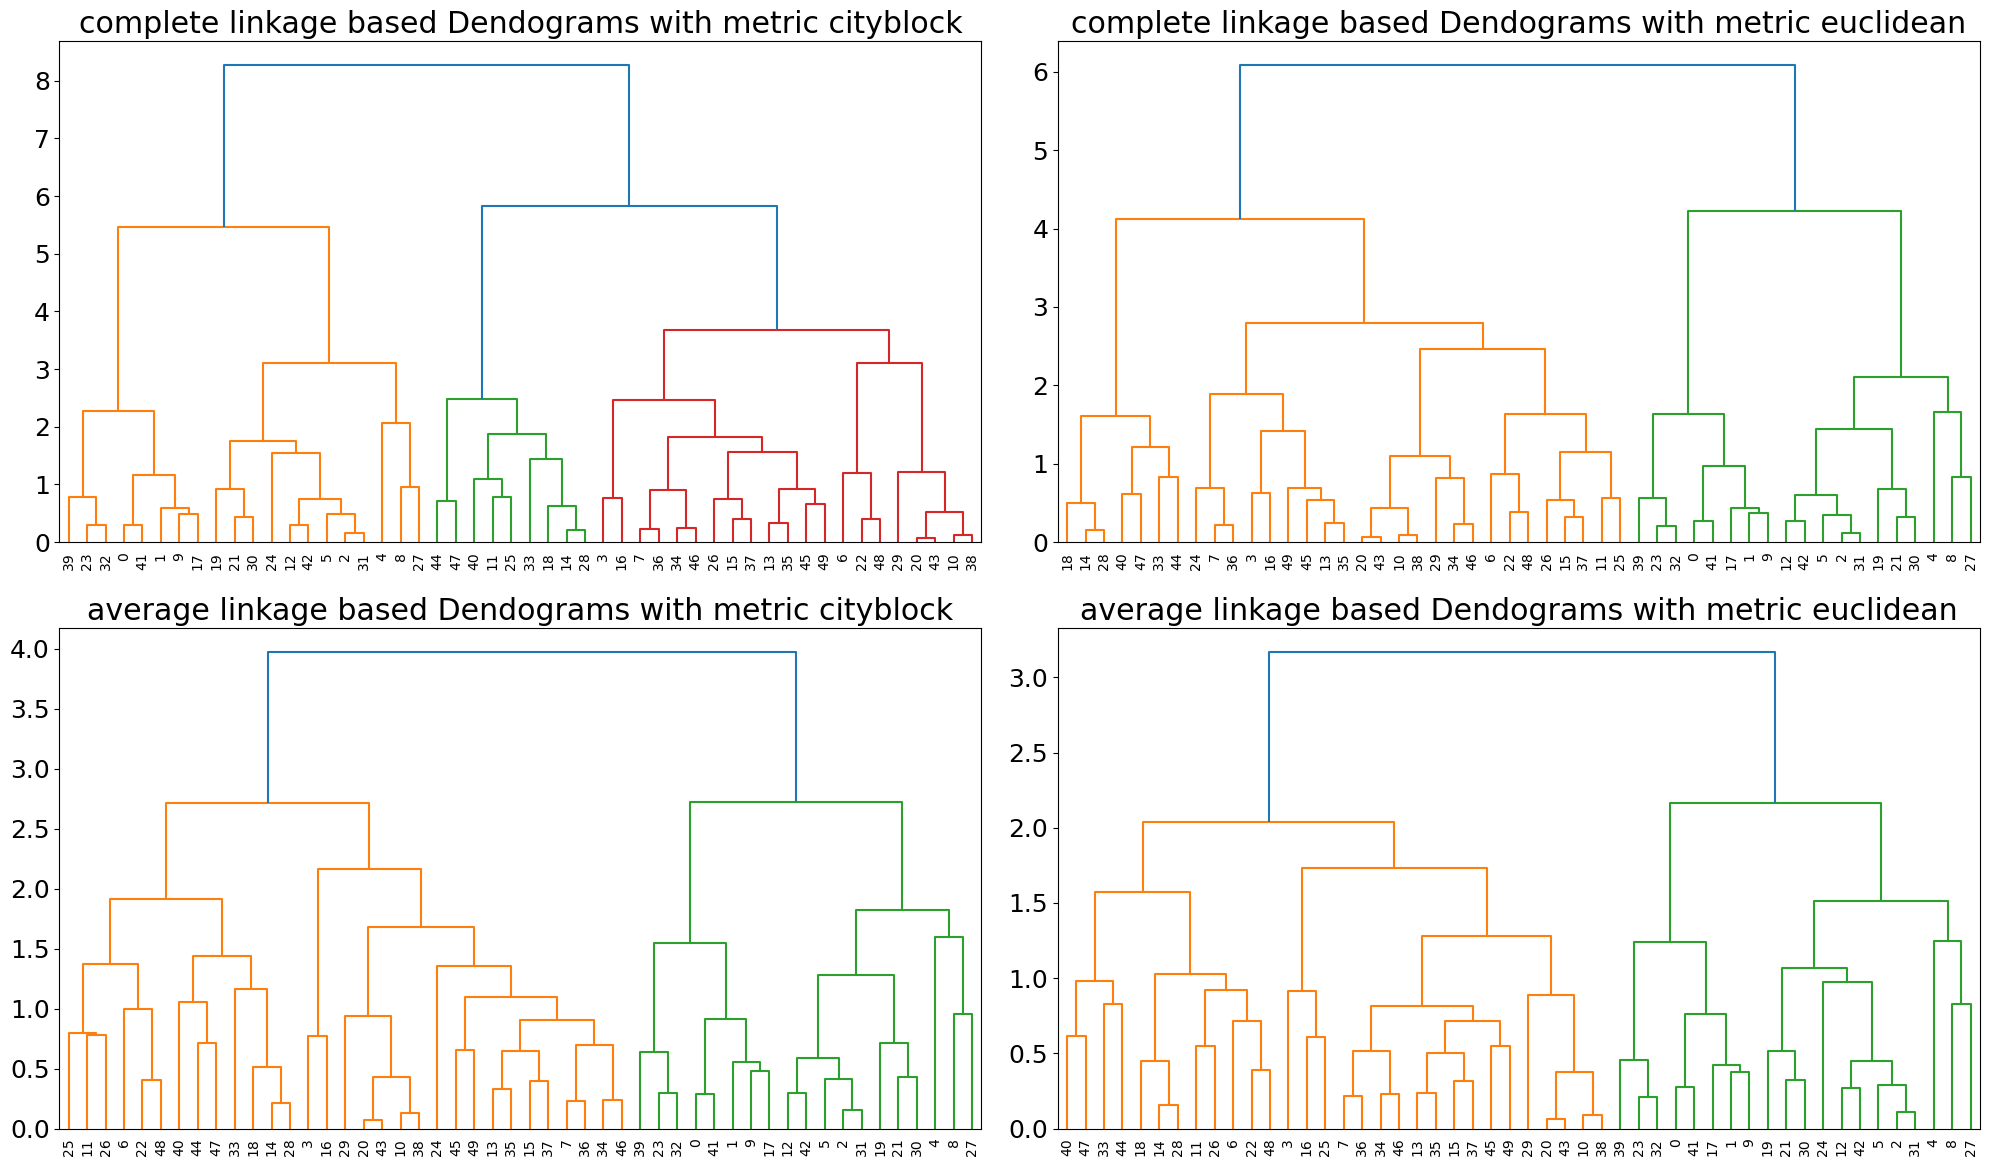

In [81]:
# plot dendrogram
# Using single and complete linkages, 
# and Euclidean and Cityblock distance metrics
linkage_types = ['complete', 'average']
metric_type = ['cityblock', 'euclidean']

f, ax = plt.subplots(2, 2, figsize=(20, 12))  # Increased the figure size

for i, l in enumerate(linkage_types):
    for j, m in enumerate(metric_type):
        dend = dendrogram(linkage(principal_components, method=l, metric=m), ax=ax[i, j], leaf_rotation=90, leaf_font_size=10)  # Rotated x-axis labels and reduced font size
        ax[i, j].set_title(f'{l} linkage based Dendograms with metric {m}')

plt.tight_layout()  # This ensures there's enough space between subplots

I have chosen metric cityblock and linkage complete, based on looking at the dendogram using those parameters I will investigate using n clusters 3.  

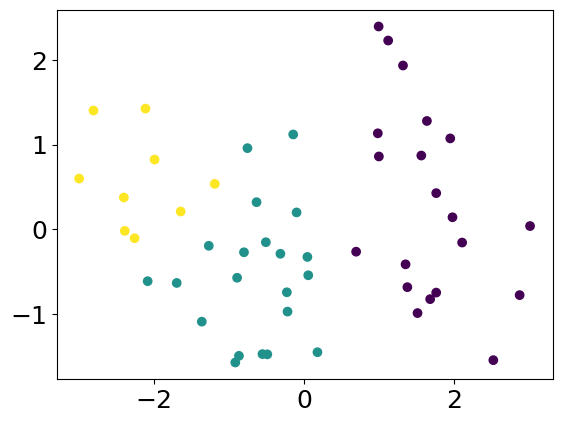

In [47]:
# agglomerative hierarchical clustering cityblock, complete, 3 n cluster
model_agg = AgglomerativeClustering(n_clusters=3, metric='cityblock', linkage="complete")
model_agg.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg.labels_)

Silhoette score for n cluster=3. The silhouette score indicates a weak structure of the clusters. While not particularly high, still indicates that there is some structure in the data, and that the clusters formed are not random. Given that this score is closer to 0 than 1, it could suggest that the data points may not be close to the centroids of their assigned clusters and/or there may be some overlap between clusters. It might be useful to further explore the data as the silhouette score is just one metric.

In [48]:
cl = model_agg.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl)}')

Silhouette score: 0.40407578036574116


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


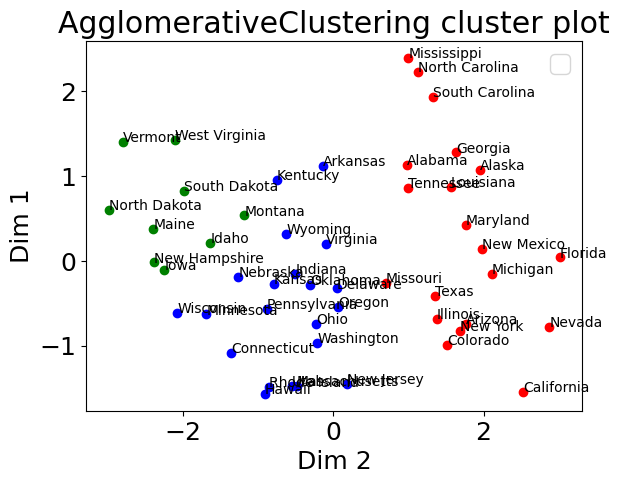

In [78]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,3):
    ax.scatter(x[cl == i],y[cl == i],c = colours[i]) 
for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]), fontsize=10)
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [50]:
# add cluster groups for k = 3 to df
add_cluster_groups(cl, 'agg_3cluster')

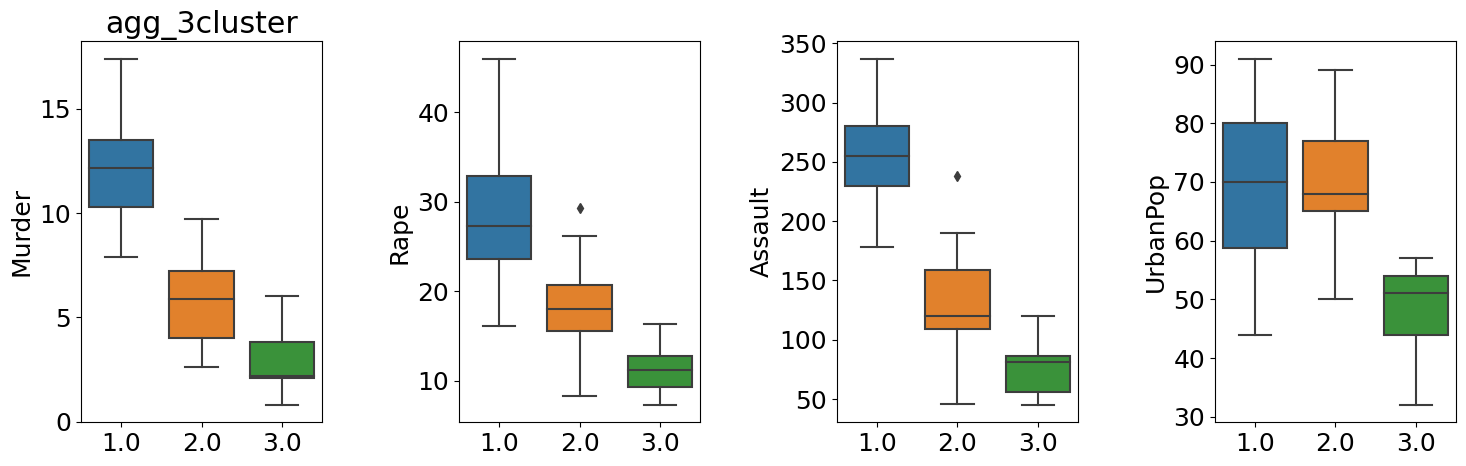

In [73]:
# Boxplots to display distribution of crime rates for the states in cluster 1-3.
plot_boxplots('agg_3cluster', df)


The boxplot reveals three distinct groups within our data. Cluster one is characterized by relatively higher arrest rates and a higher level of urban population ('UrbanPop'). This cluster also shows a relatively large spread in the data, which aligns with our earlier observation of a weak silhouette score, indicating less tightly grouped clusters.

Cluster two stands out with its relatively low arrest rates but high 'UrbanPop'. This might suggest that despite having a higher urban population, these states have lower rates of the crimes we're measuring.

Cluster three, on the other hand, exhibits the lowest scores across all features. This could represent states with both lower urban population and lower crime rates.

It's also worth noting the presence of outliers in cluster two. These could represent states with unusually high crime rates given their urban population level or other unique characteristics. Understanding these outliers might provide additional insights into the factors influencing crime rates.

The dendrogram are not a perfect system for choosing n clusters. I also wanted to compare distinct cluster groups to my K-Means model (k=4), so have included n clusters 4, metric cityblock and linkage complete to investigate further.

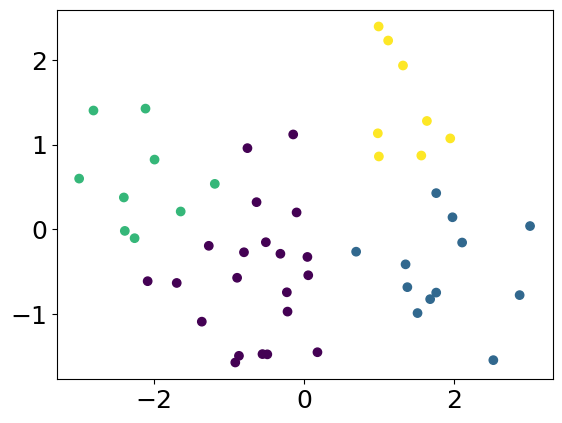

In [52]:
# agglomerative hierarchical clustering cityblock, complete, 4 n cluster
model_agg_4 = AgglomerativeClustering(n_clusters=4, metric='cityblock', linkage="complete")
model_agg_4.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg_4.labels_)

In [53]:
# silhouette score
cl_4 = model_agg_4.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl_4)}')

Silhouette score: 0.42185754446375023


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


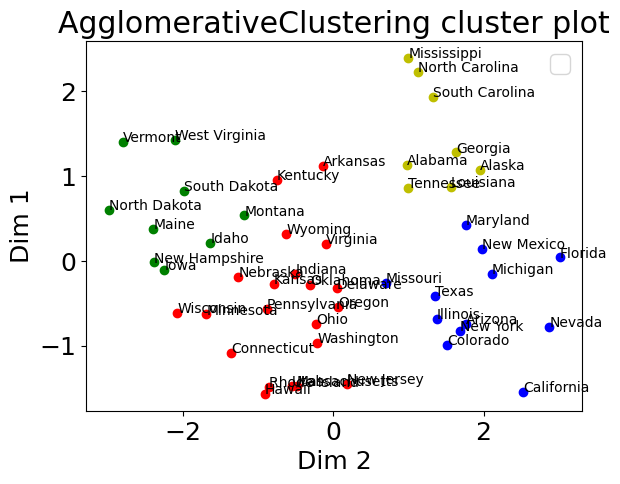

In [79]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,4):
    ax.scatter(x[cl_4 == i],y[cl_4 == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]), fontsize=10)
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [55]:
# add cluster groups for k = 4 to df
add_cluster_groups(cl_4, 'agg_4cluster')

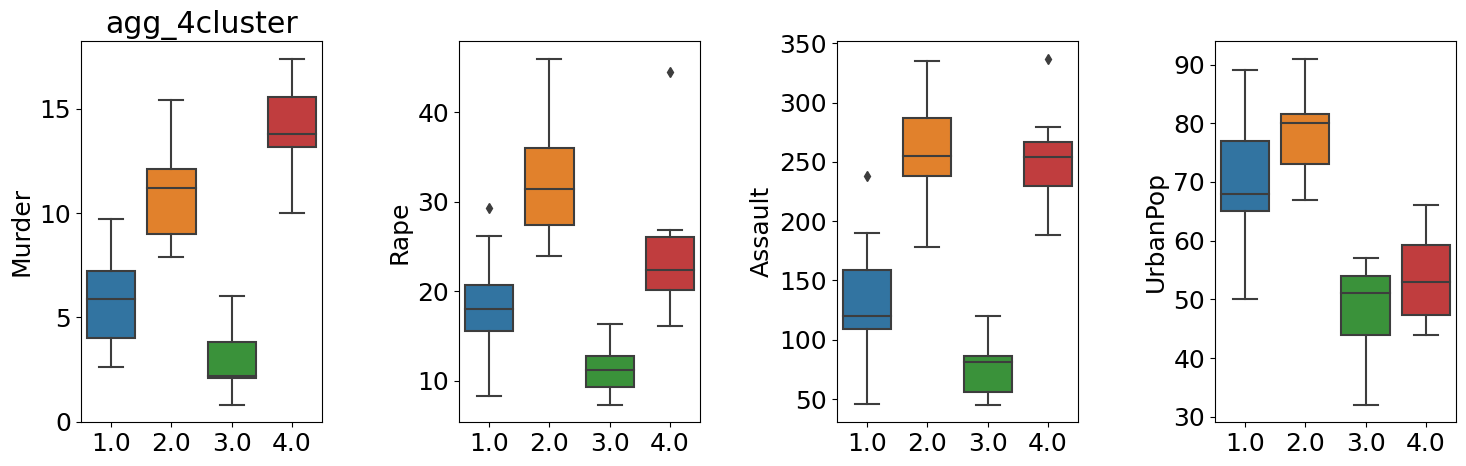

In [74]:
# Boxplots to display distribution of crime rates for the states in cluster 1-4.
plot_boxplots('agg_4cluster', df)



The boxplot depicts differences across the four clusters. Cluster 1 is characterized by lower rates of arrest across all crime metrics (Murder, Assault, and Rape) but has a higher UrbanPop, suggesting that despite having a larger urban population, these states manage to maintain lower crime rates.

Cluster 2, on the other hand, shows relatively high rates across all features, indicating that these states experience higher crime rates even while factoring in their urban population levels.

Cluster 3 states also exhibit lower rates of arrest across all features, similar to cluster 1. However, without reference to UrbanPop, it's unclear if this is due to smaller urban populations or more effective crime prevention methods.

Cluster 4 is a bit unique, with high murder rates and assault rates, yet medium scores for rape. Its UrbanPop is lower compared to clusters 1 and 2, but higher than cluster 3. This could suggest a unique set of conditions where certain types of crime are more prevalent than others despite a not particularly high urban population.

Finally, it's also important to note the presence of outliers in the data. These outliers could represent states with unique circumstances that cause them to diverge from the general trends observed within their respective clusters

I also wanted to compare distinct cluster groups to my K-Means model (k=2), so have included n clusters 2, metric cityblock and linkage complete to investigate further.

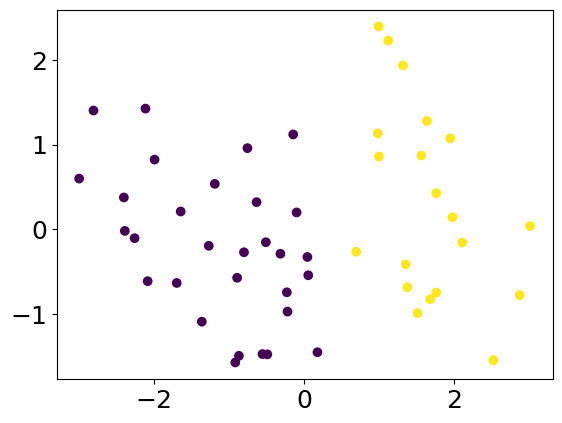

In [57]:
# agglomerative hierarchical clustering cityblock, complete, 4 n cluster
model_agg_2 = AgglomerativeClustering(n_clusters=2, metric='cityblock', linkage="complete")
model_agg_2.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg_2.labels_)

In [58]:
# silhouette score
cl_2 = model_agg_2.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl_2)}')

Silhouette score: 0.4758031477075563


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


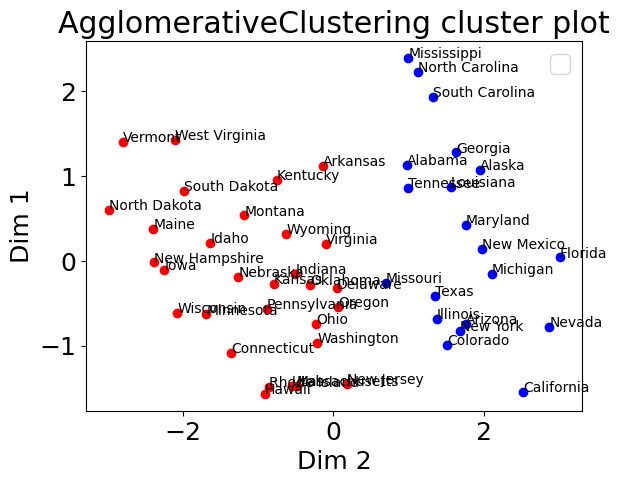

In [80]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,2):
    ax.scatter(x[cl_2 == i],y[cl_2 == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]), fontsize=10)
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [60]:
# add cluster groups for k = 2 to df
add_cluster_groups(cl_2, 'agg_2cluster')

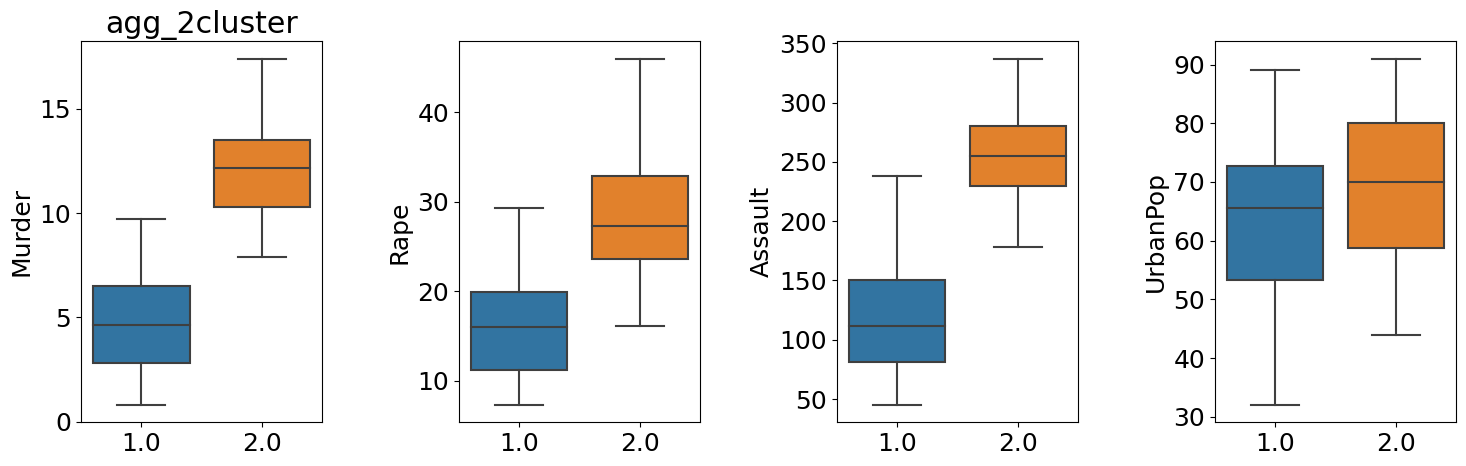

In [75]:
# Boxplots to display distribution of crime rates for the states in cluster 1-3.
plot_boxplots('agg_2cluster', df)


From the box plots above, 

The boxplot presents significant contrasts between cluster 1 and cluster 2 in terms of crime rates. In general, states belonging to cluster 1 exhibit lower minimum, maximum, and median values for Murder, Assault, and Rape compared to those in cluster 2.

States in cluster 2, on the other hand, have noticeably higher average crime rates. While there is a certain degree of overlap between the two clusters, we can generally categorize cluster 2 as comprising higher-risk states due to their elevated crime metrics.

In terms of UrbanPop, cluster 1 shows slightly lower median and mean values than cluster 2, suggesting a smaller urban population on average. However, cluster 1 exhibits a larger spread of data and a lower minimum value, indicating greater variability among the states within this cluster in terms of their urban populations.

In conclusion, these distinctions imply differing socio-economic and law enforcement conditions between the states in these two clusters, which could be further explored in additional analyses. 

## Summary

Throughout this analysis, I've delved into the US Arrests data from 1973, which records the arrests per 100,000 residents in each of the 50 states. The investigation employed several unsupervised learning models, including Principal Component Analysis (PCA), K-means, and Hierarchical Clustering.

Both Hierarchical Clustering and K-means clustering yielded similar groupings of states. When configured with two clusters, both models broadly divided the states into groups based on low and high arrest rates. Although there was some clustering observed in relation to UrbanPop, it was not categorically defining.

With larger numbers of clusters (3 and 4), the models maintained a similar trend of separating states into low and high arrest rate groups. However, a more distinct pattern concerning UrbanPop was noticeable. States were grouped based on varying combinations of high/low arrest rates and UrbanPop – low arrests with high UrbanPop, high arrests with high UrbanPop, and high arrests with low UrbanPop. Visualizing these groupings with a traffic light system – low (green), medium (amber), and high (red) arrest rates – could prove effective in showcasing these patterns.

The Silhouette scores generated from the analysis, however, were relatively weak, with the model_agg_2 scoring the highest at 48. This is consistent with the wide spread and presence of outliers in the data as visualized in the boxplots. Despite the weak Silhouette scores, both models offered valuable insights and patterns, even though they aren't definitive. Consequently, additional analyses would be required to draw stronger conclusions from the data.

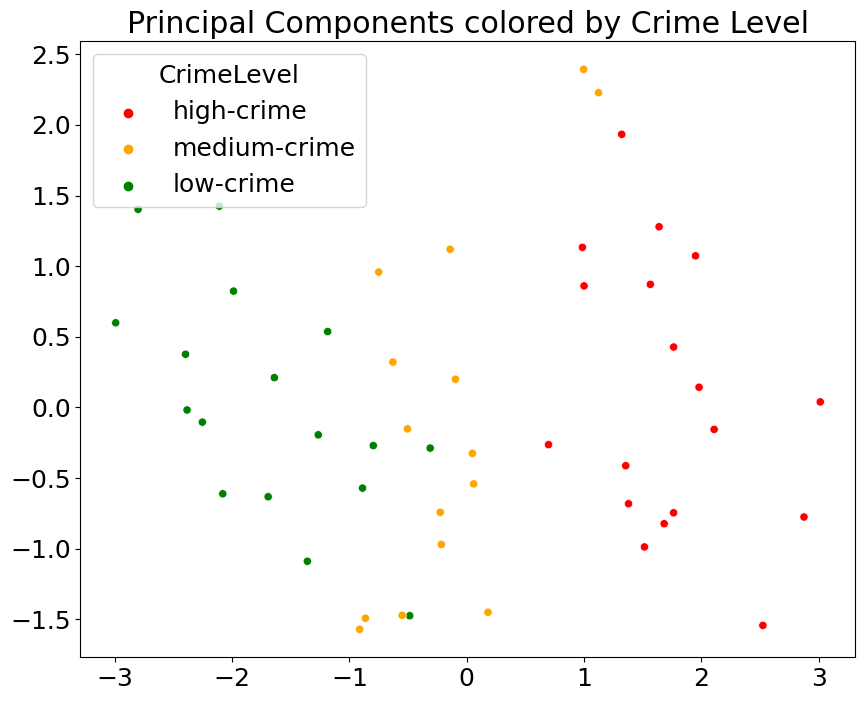

In [62]:
# Create a dictionary to map CrimeLevel to colors
colors = {'low-crime': 'green', 'medium-crime': 'orange', 'high-crime': 'red'}

# Create a scatter plot of your PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], data=df_crime_level, hue='CrimeLevel', palette=colors)
plt.title('Principal Components colored by Crime Level')
plt.show()
